# Multi Race model
> May 2024

In [1]:
#| default_exp multi_race

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
/home/ethos/git/gh-pages-example/gh_pages_example/methods.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  ergodic = np.array(V.transpose(0, 2, 1)[y], dtype=float)


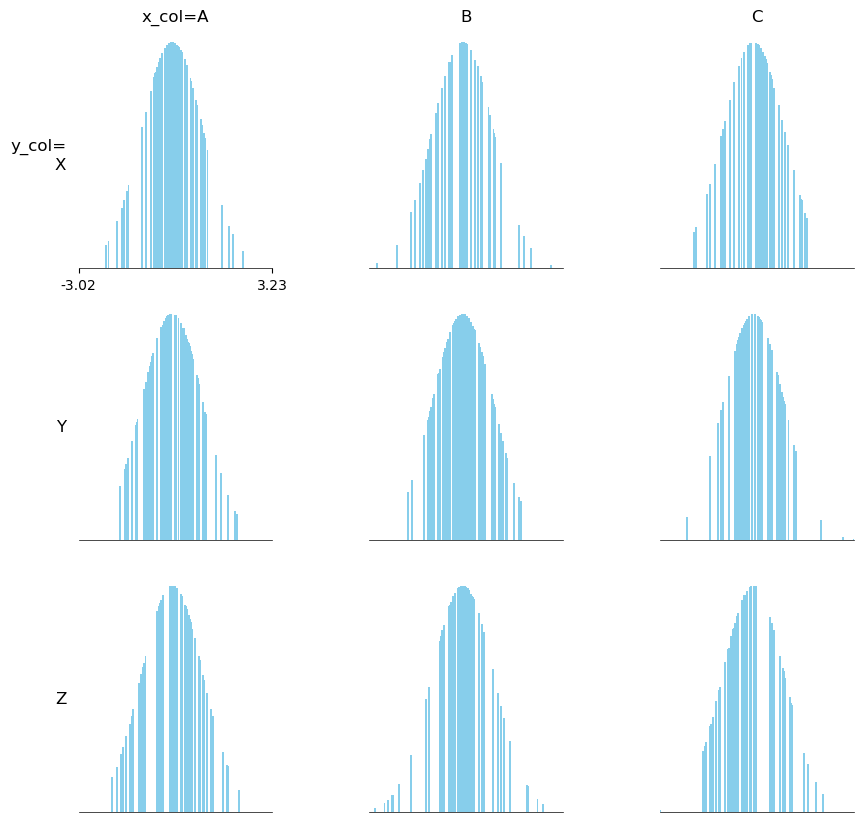

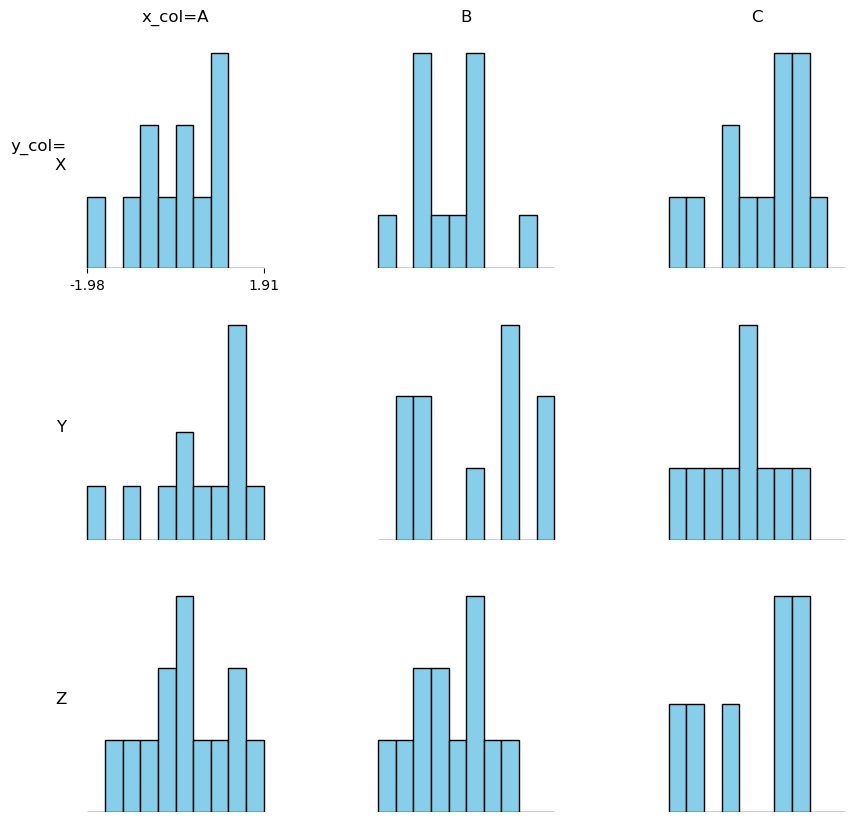

In [2]:
#| hide
#| export
from gh_pages_example.conditions import *
from gh_pages_example.data_utils import *
from gh_pages_example.methods import *
from gh_pages_example.models import *
from gh_pages_example.model_utils import *
from gh_pages_example.payoffs import *
from gh_pages_example.plot_utils import *
from gh_pages_example.types import *
from gh_pages_example.utils import *

import copy
import typing
import warnings

import chaospy
import fastcore.test
import ipywidgets
from ipywidgets import interact
import matplotlib as mpl
import matplotlib.pyplot as plt
from nbdev.showdoc import *
import nptyping
import numpy as np
import pandas
import plotly.express as px
import scipy
import seaborn as sns
import tqdm

Given that $W1/s1 < W2/s2  < W1 < W2$, we can mark which recurrent states lead to each lab type being safe.

L1 safe when:\
AS-AS\
AU-AS\
S1-AS\
S2-AS\
AS-S1\
S1-S1

Intuitively, L1 cannot be safe if they choose AU or S2 (they always make the breakthrough first and do so unsafely). When choosing S1, they are only safe if they can make their breakthrough before L2, which given our above constraints requires that L2 is safe in their first phase.

L2 safe when:\
AS-AS\
AS-S1\
AS-S2\
AS-AU\
S2-AU\
S2-S2

Intuitively, L2 cannot be safe if they choose AU or S1 (when choosing S1, they cannot reach their breakthrough before L2 given our selected region of the parameter space, so will always switch to being unsafe). When choosing S2, they will only switch to be safe if L1 reaches their breakthrough first, which requires them to be unsafe in the first phase.

Notice that only the following recurrent states lead to both lab types being safe:\
AS-AS\
AS-S1

We propose the following method of aggregating the harms:
$
Harm = Pr(both safe) * 0 + Pr(L1 safe only) * (1-p_2) * B2 / (B1 + B2) + Pr(L2 safe only) * (1-p_1) * B1 / (B1 + B2) + pr(both unsafe) * (1-p_{both})
$

In [3]:
# | export payoffs
# helper functions
def market_share(t_1, t_2, gamma):
   """Compute market share of the player who arrives at the discovery at time `t_1`."""
   dt = np.abs(t_1 - t_2)
   market_shares = np.where(t_2 <= t_1,
                   0.5*gamma**dt,
                   1 - 0.5*gamma**dt)
   return market_shares
def market_value(b, delta, t, w):
   """Compute the net present value of the market with monetary value `b` to a
   player who enters the market at time `t` given their discount rate, `delta`.
   
   A negative delta is nonsensical so we simply assume a very large benefit
   no matter the value of t. Likewise if delta=1, instead of assuming infinite
   payoffs, we assume a large value for the prize, capped at b*100"""
   return np.where((0 < delta) & (delta < 1),
                  #  b * delta**t / (1 - delta),
                  #  100 * b,
                  w / t * b,
                  w / t * b)
def catch_up_fn(t, w, s_p1, s_p2):
   """Compute the spillover adjusted arrival time if a player from the other
   layer makes a breakthrough at time `t`."""
   return np.where(s_p2 > 0,
                   (t + ((w - t * s_p1) / s_p2)),
                   1e100)

def build_payoffs_multi_race_v1(models):
   """ 
   Builds the payoffs for the multi race model of AI development.
   
   Note: This model assumes only two layers interact with one another at a time.
   Currently, we've hardcoded these parameters, but in future we could refactor
   the parameters to be 2d arrays instead of 1d arrays and use them as needed.

   Note: The interaction should only be between two layers at a time.
   More complex interactions should be decomposed into simpler ones.
   """
   # Extract the parameters from the models dictionary.
   names1 = ["B_1", "B_2", "s_1", "s_2", "p_1", "p_2", "p_both"]
   names2 = [ "W_1", "W_2", "gamma_1", "gamma_2", "delta_1", "delta_2", "alpha_1", "alpha_2"]
   B_1, B_2, s_1, s_2, p_1, p_2, p_both = [models[k] for k in names1]
   W_1, W_2, gamma_1, gamma_2, delta_1, delta_2, alpha_1, alpha_2  = [models[k] for k in names2]
   profile = models["profile"]
   strategy_profile = [int(a) for a in profile.split("-")][::-1]
   M = np.shape(B_1)[0]
   N = len(strategy_profile)
   
   # The following collections of parameters are specified per strategy. 
   # Each layer allows the following strategies:
   # safe, unsafe, safe_phase_1, safe_phase_2
   mapping_s_to_irt = [W_1, W_1/s_1, W_1, W_1/s_1,
                       W_2, W_2/s_2, W_2, W_2/s_2] # short for mapping_strategy_to_isolated_research_time
   ones = np.ones(M)
   mapping_s_to_phase1_speed = [ones, s_1, ones, s_1,
                                ones, s_2, ones, s_2]
   mapping_s_to_phase2_speed = [alpha_1, alpha_1 * s_1, alpha_1 * s_1, alpha_1,
                                alpha_2, alpha_2 * s_2, alpha_2 * s_2, alpha_2]
   maping_s_to_w = [W_1, W_1, W_1, W_1,
                    W_2, W_2, W_2, W_2]
   mapping_s_to_gamma = [gamma_1, gamma_1, gamma_1, gamma_1,
                         gamma_2, gamma_2, gamma_2, gamma_2]
   mapping_s_to_delta = [delta_1, delta_1, delta_1, delta_1,
                         delta_2, delta_2, delta_2, delta_2]
   mapping_s_to_b = [B_1, B_1, B_1, B_1,
                     B_2, B_2, B_2, B_2]
   mapping_s_to_alpha = [alpha_1, alpha_1, alpha_1, alpha_1,
                         alpha_2, alpha_2, alpha_2, alpha_2]
   
   # The following collection of parameters are specified per player
   # We usually do this to make broadcasting our functions over arrays easier
   isolated_research_times = np.array([mapping_s_to_irt[a - 1] for a in strategy_profile]).T
   phase_1_speeds = np.array([mapping_s_to_phase1_speed[a - 1] for a in strategy_profile]).T
   phase_2_speeds = np.array([mapping_s_to_phase2_speed[a - 1] for a in strategy_profile]).T
   research_distances = np.array([maping_s_to_w[a - 1] for a in strategy_profile]).T
   contestability_rates = np.array([mapping_s_to_gamma[a - 1] for a in strategy_profile]).T
   discount_rates = np.array([mapping_s_to_delta[a - 1] for a in strategy_profile]).T
   benefits = np.array([mapping_s_to_b[a - 1] for a in strategy_profile]).T
   safety_boosts = np.array([mapping_s_to_alpha[a - 1] for a in strategy_profile]).T

   # Define layer membership for each player
   layer_membership = np.zeros((M, N))
   for i, a in enumerate(strategy_profile):
      # First 4 strategies belong to layer 1, the rest belong to layer 2
      layer_membership[:, i] = 1 if a > 4 else 0

   # Determine leader and leader arrival time
   leader = np.argmin(isolated_research_times, axis=1)
   is_leader = np.zeros((M, N), dtype=bool)
   is_leader[np.arange(M), leader] = True
   leader_layer = layer_membership[np.arange(M), leader][:, None]
   arrival_time_leader = np.min(isolated_research_times, axis=1, keepdims=True)
   

   # Compute times until each player achieves their AI breakthrough given their strategies
   arrival_times = isolated_research_times
   on_late_layer = layer_membership != leader_layer
   on_leader_layer = layer_membership == leader_layer
   
   catch_up_times =  catch_up_fn(arrival_time_leader,
                                 research_distances,
                                 phase_1_speeds,
                                 phase_2_speeds)
   arrival_times = np.where(on_late_layer, catch_up_times, arrival_times)
   arrival_times_follower_layer = arrival_times[on_late_layer].reshape((M, 2))
   
   # Revise arrival times for players on the leading layer who are behind the other layer   
   arrival_time_follower = np.min(arrival_times_follower_layer, axis=1, keepdims=True)
   after_follower = arrival_times > arrival_time_follower
   catch_up_times_crossover = catch_up_fn(arrival_time_follower,
                                          research_distances,
                                          phase_1_speeds,
                                          phase_2_speeds)
   arrival_times = np.where(on_leader_layer & after_follower, catch_up_times_crossover, arrival_times)
   
   # Compute times until each player would achieve a safe AI given their strategies
   safe_times = research_distances
   safe_time_catch_up = catch_up_fn(arrival_time_leader,
                                    research_distances,
                                    phase_1_speeds,
                                    safety_boosts)
   safe_times = np.where(~on_leader_layer, safe_time_catch_up, safe_times)
   # Revise safe times for players on the leading layer who are behind the other layer   
   safe_times_crossover = catch_up_fn(arrival_time_follower,
                                      research_distances,
                                      phase_1_speeds,
                                      safety_boosts)
   safe_times = np.where(on_leader_layer & after_follower, safe_times_crossover, safe_times)
   
   # Record which players and layers are unsafe
   unsafe_players = safe_times > arrival_times
   unsafe_layer1 = np.any(unsafe_players[:, layer_membership[0, :] == 0], axis=1, keepdims=True)
   unsafe_layer2 = np.any(unsafe_players[:, layer_membership[0, :] == 1], axis=1, keepdims=True)
   
   # Match arrival times to the rival's arrival times for calculating market share
   rival_indices = [i+1 if i % 2 == 0 else i-1 for i in range(N)]
   arrival_times_rival = arrival_times[:, rival_indices]
   
   # Determine harms for each player
   unsafe_scenario_1 = unsafe_players & unsafe_layer1 & ~unsafe_layer2
   unsafe_scenario_2 = unsafe_players & ~unsafe_layer1 & unsafe_layer2
   unsafe_scenario_3 = unsafe_players & unsafe_layer1 & unsafe_layer2
   harms = np.zeros((M, N))
   harms = np.where(unsafe_scenario_1, 1 - p_1[:, None], harms)
   harms = np.where(unsafe_scenario_2, 1 - p_2[:, None], harms)
   harms = np.where(unsafe_scenario_3, 1 - p_1[:, None] * p_2[:, None], harms)
   
   # Given arrival times and safe times, as well as the equations for market
   # value, market share, and risk, we can now compute the payoffs.
   market_shares = market_share(arrival_times, arrival_times_rival, contestability_rates)
   market_values = market_value(benefits, discount_rates, arrival_times, research_distances)
   payoff_values = market_shares * market_values * (1 - harms)

   # Helpful assertions:
   
   # Check that it is impossible for any player to have made their breakthrough
   # in phase 1 without covering their research distance (as this must be true
   # by construction, this only happens if we have a bug in the code).
   
   assert np.all(research_distances >= np.round(arrival_time_leader * phase_1_speeds, 3))
   
   payoffs = {f"P{i+1}": payoff_values[:, i] for i in range(N)}
   return {"payoffs": payoffs,
           "arrival_times": arrival_times,
           "safe_times": safe_times}

@method(build_payoffs, "multi-race-v1")
def build_payoffs(models):
   """Payoff matrix for the Multi Race game."""
   profiles = models["profiles_filtered"]

   models["payoffs"] = {}
   models["arrival_times"] = {}
   models["safe_times"] = {}
   for profile in tqdm.tqdm(profiles):
      models["profile"] = profile
      # Build payoffs for the current profile
      data = build_payoffs_multi_race_v1(models)
      models["payoffs"][profile] = data["payoffs"]
      models["arrival_times"][profile] = data["arrival_times"]
      models["safe_times"][profile] = data["safe_times"]

   return models

In [4]:
import nbdev; nbdev.nbdev_export()

In [5]:
def compute_harm_baseline(models):
    """Compute a random harm baseline for comparison"""
    names = ["p_1", "p_2", "p_both", "B_1", "B_2", "recurrent_states"]
    p_1, p_2, p_both, B_1, B_2, recurrent_states = [models[k] for k in names]
    # l1_safe = ["AS-AS", "AU-AS", "S1-AS", "S2-AS", "AS-S1", "S1-S1"]
    l1_safe = ["5-1", "6-1", "7-1", "8-1", "5-3", "6-3"]
    # l2_safe = ["AS-AS", "AS-S1", "AS-S2", "AS-AU", "S2-AU", "S2-S2"]
    l2_safe = ["5-1", "5-3", "5-4", "5-2", "8-2", "8-4"]
    both_safe = set(l1_safe) & set(l2_safe)
    l1_safe_only = set(l1_safe) - both_safe
    l2_safe_only = set(l2_safe) - both_safe
    both_unsafe = set(recurrent_states) - set(l1_safe) - set(l2_safe)
    S = len(recurrent_states)
    S_L1 = len(l1_safe_only)
    S_L2 = len(l2_safe_only)
    S_0 = len(both_unsafe)
    harm_baseline = (S_L1/S * (1 - p_2) * B_2 / (B_1 + B_2)
                     + S_L2/S * (1 - p_1) * B_1 / (B_1 + B_2)
                     + S_0/S * (1 - p_both))
    return {**models, "harm_baseline": harm_baseline}

def compute_harm(models):
    """Compute the harm given the frequency of each state."""
    names = ["p_1", "p_2", "p_both", "B_1", "B_2", "recurrent_states"]
    # TODO: recurrent_states should be stored as recurrent_states.
    # Currently, it is stored as strategy_set.
    p_1, p_2, p_both, B_1, B_2, recurrent_states = [models[k] for k in names]
    ergodic = models["ergodic"]
    # l1_safe = ["AS-AS", "AU-AS", "S1-AS", "S2-AS", "AS-S1", "S1-S1"]
    l1_safe = ["5-1", "6-1", "7-1", "8-1", "5-3", "6-3"]
    # l2_safe = ["AS-AS", "AS-S1", "AS-S2", "AS-AU", "S2-AU", "S2-S2"]
    l2_safe = ["5-1", "5-3", "5-4", "5-2", "8-2", "8-4"]
    both_safe = set(l1_safe) & set(l2_safe)
    l1_safe_only = set(l1_safe) - both_safe
    l2_safe_only = set(l2_safe) - both_safe
    both_unsafe = set(recurrent_states) - set(l1_safe) - set(l2_safe)
    unsafe_states = [i for i, state in enumerate(recurrent_states)
                     if state in both_unsafe]
    l1_safe_only_states = [i for i, state in enumerate(recurrent_states)
                           if state in l1_safe_only]
    l2_safe_only_states = [i for i, state in enumerate(recurrent_states)
                           if state in l2_safe_only]
    pr_both_unsafe = np.sum(ergodic[:, unsafe_states],axis=1)
    pr_l1_safe_only = np.sum(ergodic[:, l1_safe_only_states],axis=1)
    pr_l2_safe_only = np.sum(ergodic[:, l2_safe_only_states],axis=1)
    harm = (pr_l1_safe_only * (1 - p_2) * B_2 / (B_1 + B_2)
            + pr_l2_safe_only * (1 - p_1) * B_1 / (B_1 + B_2)
            + pr_both_unsafe * (1 - p_both))
    harm_l1 = pr_both_unsafe * (1 - p_both) + pr_l2_safe_only * (1 - p_1)
    harm_l2 = pr_both_unsafe * (1 - p_both) + pr_l1_safe_only * (1 - p_2)
    return {**models, "harm": harm, "harm_l1": harm_l1, "harm_l2": harm_l2}

In [6]:
def compute_arrival_times(models):
    """Compute the arrival times for each player in each profile."""
    arrival_times = models["arrival_times"]
    arrival_times_dict_1 = {f"arrival_times_player_1_profile_{k}": d[:, 0]
                            for k, d in arrival_times.items()}
    arrival_times_dict_2 = {f"arrival_times_player_2_profile_{k}": d[:, 1]
                            for k, d in arrival_times.items()}
    arrival_times_dict_3 = {f"arrival_times_player_3_profile_{k}": d[:, 2]
                            for k, d in arrival_times.items()}
    arrival_times_dict_4 = {f"arrival_times_player_4_profile_{k}": d[:, 3]
                            for k, d in arrival_times.items()}
    
    # We usually only care about the minimum arrival times for each layer.
    arrival_times_profiles_layer_1 = {f"arrival_times_L1_profile_{k}": np.min(d[:, :2], axis=1)
                             for k, d in arrival_times.items()}
    arrival_times_profiles_layer_2 = {f"arrival_times_L2_profile_{k}": np.min(d[:, 2:4], axis=1)
                             for k, d in arrival_times.items()}
    
    # We can also record the arrival times of laggards in each layer
    arrival_times_layer_1_laggards = {f"arrival_times_L1_laggards_profile_{k}": np.max(d[:, :2], axis=1)
                                      for k, d in arrival_times.items()}
    arrival_times_layer_2_laggards = {f"arrival_times_L2_laggards_profile_{k}": np.max(d[:, 2:4], axis=1)
                                      for k, d in arrival_times.items()}
    
    # We can also record the average arrival times for the layer given the
    # ergodic distribution of the model
    recurrent_states = models["recurrent_states"]
    ergodic = models["ergodic"]
    arrival_times_layer_1_mean = np.zeros(ergodic.shape[0])
    arrival_times_layer_2_mean = np.zeros(ergodic.shape[0])
    for i, rs in enumerate(recurrent_states):
        s = rs.split("-")
        state = "-".join([s[0], s[0], s[1], s[1]])
        arrival_times_layer_1_mean += ergodic[:, i] * arrival_times_profiles_layer_1[f"arrival_times_L1_profile_{state}"]
        arrival_times_layer_2_mean += ergodic[:, i] * arrival_times_profiles_layer_2[f"arrival_times_L2_profile_{state}"]
    
    return {**models,
            "arrival_times_layer_1_mean": arrival_times_layer_1_mean,
            "arrival_times_layer_2_mean": arrival_times_layer_2_mean,
            **arrival_times_profiles_layer_1,
            **arrival_times_profiles_layer_2,
            **arrival_times_layer_1_laggards,
            **arrival_times_layer_2_laggards,
            **arrival_times_dict_1,
            **arrival_times_dict_2,
            **arrival_times_dict_3,
            **arrival_times_dict_4}
    
def compute_safe_times(models):
    """Compute the safe times for each player in each profile."""
    safe_times = models["safe_times"]
    safe_times_dict_1 = {f"safe_times_player_1_profile_{k}": d[:, 0]
                         for k, d in safe_times.items()}
    safe_times_dict_2 = {f"safe_times_player_2_profile_{k}": d[:, 1]
                         for k, d in safe_times.items()}
    safe_times_dict_3 = {f"safe_times_player_3_profile_{k}": d[:, 2]
                         for k, d in safe_times.items()}
    safe_times_dict_4 = {f"safe_times_player_4_profile_{k}": d[:, 3]
                         for k, d in safe_times.items()}
    
    # We usually only care about the minimum safe times for each layer.
    safe_times_profiles_layer_1 = {f"safe_times_L1_profile_{k}": np.min(d[:, :2], axis=1)
                             for k, d in safe_times.items()}
    safe_times_profiles_layer_2 = {f"safe_times_L2_profile_{k}": np.min(d[:, 2:4], axis=1)
                             for k, d in safe_times.items()}
    
    # We can also record the safe times of laggards in each layer
    safe_times_layer_1_laggards = {f"safe_times_L1_laggards_profile_{k}": np.max(d[:, :2], axis=1)
                                   for k, d in safe_times.items()}
    safe_times_layer_2_laggards = {f"safe_times_L2_laggards_profile_{k}": np.max(d[:, 2:4], axis=1)
                                   for k, d in safe_times.items()}
    
    # We can also record the average safe times for the layer given the
    # ergodic distribution of the model
    recurrent_states = models["recurrent_states"]
    ergodic = models["ergodic"]
    safe_times_layer_1_mean = np.zeros(ergodic.shape[0])
    safe_times_layer_2_mean = np.zeros(ergodic.shape[0])
    for i, rs in enumerate(recurrent_states):
        s = rs.split("-")
        state = "-".join([s[0], s[0], s[1], s[1]])
        safe_times_layer_1_mean += ergodic[:, i] * safe_times_profiles_layer_1[f"safe_times_L1_profile_{state}"]
        safe_times_layer_2_mean += ergodic[:, i] * safe_times_profiles_layer_2[f"safe_times_L2_profile_{state}"]
    
    return {**models,
            "safe_times_layer_1_mean": safe_times_layer_1_mean,
            "safe_times_layer_2_mean": safe_times_layer_2_mean,
            **safe_times_profiles_layer_1,
            **safe_times_profiles_layer_2,
            **safe_times_layer_1_laggards,
            **safe_times_layer_2_laggards,
            **safe_times_dict_1,
            **safe_times_dict_2,
            **safe_times_dict_3,
            **safe_times_dict_4}

In [7]:
def map_state_color(state, recurrent_states):
    """Map state to a color for plotting purposes."""
    l1_safe = ["AS-AS", "AU-AS", "S1-AS", "S2-AS", "AS-S1", "S1-S1"]
    l2_safe = ["AS-AS", "AS-S1", "AS-S2", "AS-AU", "S2-AU", "S2-S2"]
    both_safe = set(l1_safe) & set(l2_safe)
    l1_safe_only = set(l1_safe) - both_safe
    l2_safe_only = set(l2_safe) - both_safe
    both_unsafe = set(recurrent_states) - set(l1_safe) - set(l2_safe)
    if state in both_unsafe:
        return "#ff9000"
    if state in l1_safe_only:
        return "#FFD700"
    if state in l2_safe_only:
        return "#FFD700"
    if state in both_safe:
        return "#90EE90"
    return None

When planning how many models to run, calculate the memory (in GB) used to store the payoffs as follows:

In [8]:
n_models_planned = 40000
x = np.random.random((n_models_planned, 4))
gb_size = lambda x: x.nbytes / (1024 ** 3) # Size in GB
total_size = lambda x: gb_size(x) * 16**2 * 4
total_size(x), total_size(x.astype(np.float32)), total_size(x.astype(np.float16))

(1.220703125, 0.6103515625, 0.30517578125)

In [9]:
Z = {"S2": 100, "S1": 100}
β = 0.1
sector_strategies = {"S2": [8],
                     "S1": [1, 2],}
allowed_sectors = {"P4": ["S2"],
                   "P3": ["S2"],
                   "P2": ["S1"],
                   "P1": ["S1"], }
models = build_multi_race(p_2=0.5,
                          s_2=3,
                          p_1={"start": 0.02,
                               "stop": 1.02,
                               "step": 0.02},
                          s_1={"start": 1.50,
                               "stop": 5.02,
                               "step": 0.02},
                          gamma_1=0,
                          gamma_2=0,
                          delta_1=0.9,
                          delta_2=0.9,
                          alpha_1=2,
                          alpha_2=2,
                          β=1,             
                          strategy_set=["AS", "AU", "S1", "S2",
                                        "AS", "S1", "S2", "AU"],
                          )
models = {**models,
          "dispatch-type": 'multiple-populations',
          "payoffs_key": "multi-race-v1",
          "β": β,
          "Z": Z,
          "allowed_sectors": allowed_sectors,
          "sector_strategies": sector_strategies,
          }

In [10]:
# Check the size of the created arrays using:
{k: models[k].shape for k,v in models.items() if isinstance(v, np.ndarray)}

{'s_1': (8800,),
 'p_1': (8800,),
 's_2': (8800,),
 'p_2': (8800,),
 'B_1': (8800,),
 'B_2': (8800,),
 'p_both': (8800,),
 'W_1': (8800,),
 'W_2': (8800,),
 'gamma_1': (8800,),
 'gamma_2': (8800,),
 'delta_1': (8800,),
 'delta_2': (8800,),
 'alpha_1': (8800,),
 'alpha_2': (8800,)}

In [11]:
results = thread_macro(models,
                       create_profiles,
                       apply_profile_filters,
                       build_payoffs,
                       build_transition_matrix,
                       find_ergodic_distribution,
                       compute_harm,
                       compute_arrival_times,
                       compute_safe_times,
                       )

/home/ethos/git/gh-pages-example/gh_pages_example/model_utils.py:299: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (ind not in allowed_inds) and (str(ind) not in allowed_inds):
100%|██████████| 4/4 [00:00<00:00, 117.73it/s]


In [12]:
df = thread_macro(results,
                  results_to_dataframe_egt,
                  )
df

,s_1,p_1,s_2,p_2,B_1,B_2,p_both,W_1,W_2,gamma_1,...,safe_times_player_3_profile_8-8-1-1,safe_times_player_3_profile_8-8-1-2,safe_times_player_3_profile_8-8-2-1,safe_times_player_3_profile_8-8-2-2,safe_times_player_4_profile_8-8-1-1,safe_times_player_4_profile_8-8-1-2,safe_times_player_4_profile_8-8-2-1,safe_times_player_4_profile_8-8-2-2,8-1_frequency,8-2_frequency
0,1.5,0.02,3,0.5,1000,1000,0,100,100,0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.000000e+00,0.0
1,1.5,0.04,3,0.5,1000,1000,0,100,100,0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.000000e+00,0.0
2,1.5,0.06,3,0.5,1000,1000,0,100,100,0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.000000e+00,0.0
3,1.5,0.08,3,0.5,1000,1000,0,100,100,0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.000000e+00,0.0
4,1.5,0.10,3,0.5,1000,1000,0,100,100,0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.000000e+00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,5.0,0.92,3,0.5,1000,1000,0,100,100,0,...,100.0,40.0,40.0,40.0,100.0,40.0,40.0,40.0,7.344924e-220,1.0
8796,5.0,0.94,3,0.5,1000,1000,0,100,100,0,...,100.0,40.0,40.0,40.0,100.0,40.0,40.0,40.0,7.344924e-220,1.0
8797,5.0,0.96,3,0.5,1000,1000,0,100,100,0,...,100.0,40.0,40.0,40.0,100.0,40.0,40.0,40.0,7.344924e-220,1.0
8798,5.0,0.98,3,0.5,1000,1000,0,100,100,0,...,100.0,40.0,40.0,40.0,100.0,40.0,40.0,40.0,7.342224e-220,1.0


### Debug Tests

In [13]:
{k: results[k].shape for k,v in results.items() if isinstance(v, np.ndarray)}

{'s_1': (8800,),
 'p_1': (8800,),
 's_2': (8800,),
 'p_2': (8800,),
 'B_1': (8800,),
 'B_2': (8800,),
 'p_both': (8800,),
 'W_1': (8800,),
 'W_2': (8800,),
 'gamma_1': (8800,),
 'gamma_2': (8800,),
 'delta_1': (8800,),
 'delta_2': (8800,),
 'alpha_1': (8800,),
 'alpha_2': (8800,),
 'transition_matrix': (8800, 2, 2),
 'ergodic': (8800, 2),
 'harm': (8800,),
 'harm_l1': (8800,),
 'harm_l2': (8800,),
 'arrival_times_layer_1_mean': (8800,),
 'arrival_times_layer_2_mean': (8800,),
 'arrival_times_L1_profile_8-8-1-1': (8800,),
 'arrival_times_L1_profile_8-8-1-2': (8800,),
 'arrival_times_L1_profile_8-8-2-1': (8800,),
 'arrival_times_L1_profile_8-8-2-2': (8800,),
 'arrival_times_L2_profile_8-8-1-1': (8800,),
 'arrival_times_L2_profile_8-8-1-2': (8800,),
 'arrival_times_L2_profile_8-8-2-1': (8800,),
 'arrival_times_L2_profile_8-8-2-2': (8800,),
 'arrival_times_L1_laggards_profile_8-8-1-1': (8800,),
 'arrival_times_L1_laggards_profile_8-8-1-2': (8800,),
 'arrival_times_L1_laggards_profile_8-8-2

In [14]:
result_sums = np.sum(results['ergodic'], axis=-1)
fastcore.test.test_close(result_sums, 1)

Test that the payoffs are not 0 too often

Test that the payoffs are not all identical

In [15]:
# Note that depending on paramter values, it may be possible that
# all payoffs are identical or 0 within a profile and player combination.
# So, all we do is store such cases for later inspection.

n_unique_payoffs = []
unique_payoffs_data = []
zero_payoffs_data = []
for profile, player_payoffs in results["payoffs"].items():
    for player, payoffs in player_payoffs.items():
        unique_payoffs = np.unique(np.round(payoffs, decimals=2))
        n_unique_payoffs.append(len(unique_payoffs))
        unique_payoffs_data.append((profile, player, unique_payoffs))
        zero_payoffs_data.append((profile, player, np.mean(payoffs == 0)))
        # Print statements for debugging
        # if len(unique_payoffs) > 1:
        #     print("n unique payoffs: ", len(unique_payoffs))
        # if len(unique_payoffs) == 1:
        #     print(f"profile, player, payoff: {profile}, {player}, {unique_payoffs[0]}")

In [16]:
results["payoffs"]

{'8-8-1-1': {'P1': array([750., 750., 750., ..., 750., 750., 750.]),
  'P2': array([750., 750., 750., ..., 750., 750., 750.]),
  'P3': array([750., 750., 750., ..., 750., 750., 750.]),
  'P4': array([750., 750., 750., ..., 750., 750., 750.])},
 '8-8-1-2': {'P1': array([  20.,   40.,   60., ..., 4800., 4900., 5000.]),
  'P2': array([0., 0., 0., ..., 0., 0., 0.]),
  'P3': array([  15.,   30.,   45., ..., 1250., 1250., 1250.]),
  'P4': array([  15.,   30.,   45., ..., 1250., 1250., 1250.])},
 '8-8-2-1': {'P1': array([0., 0., 0., ..., 0., 0., 0.]),
  'P2': array([  20.,   40.,   60., ..., 4800., 4900., 5000.]),
  'P3': array([  15.,   30.,   45., ..., 1250., 1250., 1250.]),
  'P4': array([  15.,   30.,   45., ..., 1250., 1250., 1250.])},
 '8-8-2-2': {'P1': array([  10.,   20.,   30., ..., 2400., 2450., 2500.]),
  'P2': array([  10.,   20.,   30., ..., 2400., 2450., 2500.]),
  'P3': array([  15.,   30.,   45., ..., 1250., 1250., 1250.]),
  'P4': array([  15.,   30.,   45., ..., 1250., 1250.

In [17]:
n_unique_payoffs[:20]
# unique_payoffs_data[:20]
# zero_payoffs_data[60:80]

[1, 1, 1, 1, 7276, 1, 151, 151, 1, 7276, 151, 151, 7215, 7215, 151, 151]

We need a sanity check that the result of keeping delta=1 and gamma=1 is that total harm is close to zero.

## Results

Make sure that we specify values of the parameters to be used when they are not varied along an axis.

In [18]:
selected_p_1 = 0.02
selected_s_1 = 1.58
selected_s_2 = 3
selected_p_2 = 0.5
# Round these columns to make sure we can match them to the selected values in case of floating point errors.
df.s_1 = np.round(df.s_1, decimals=2)
df.p_1 = np.round(df.p_1, decimals=2)
df.s_2 = np.round(df.s_2, decimals=2)
df.p_2 = np.round(df.p_2, decimals=2)
df["r_1"] = 1 - df["p_1"]
df["r_2"] = 1 - df["p_2"]

Ensure our recurrent states are labelled correctly

In [19]:
strategy_labels = results["strategy_set"]
recurrent_states_labels = ["-".join([strategy_labels[int(s)-1] for s in state.split("-")])
                           for state in results["recurrent_states"]]

Draw a Markov Chain diagram to visualize the flow of the system between different recurrent states

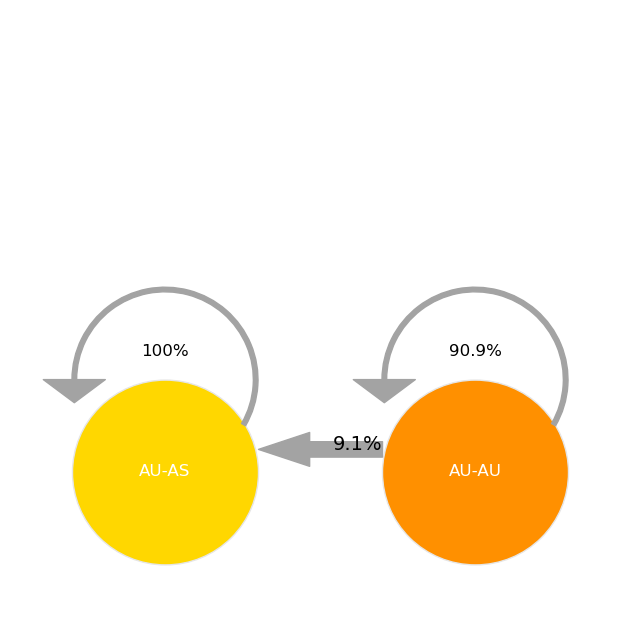

In [20]:
default_idx = df[(df.s_1==selected_s_1) & (df.p_1==selected_p_1)
                 & (df.s_2==selected_s_2) & (df.p_2==selected_p_2)].index[0]
node_facecolor = [map_state_color(state, recurrent_states_labels) for state in recurrent_states_labels]
P = np.round(results['transition_matrix'][default_idx], decimals=4)
mc = MarkovChain(P,
                 recurrent_states_labels,
                 percentages=True,
               #   self_arrows=False,
                #  annotate=False,
                 scale_xlim=0.5,
                 scale_ylim=0.5,
                 n_columns=2,
                 node_facecolor= node_facecolor,
                 transparency_func=lambda p:max(min(1, 5 * p**0.5), 0.1) if p>1e-100 else 0)
mc.draw()

Plot the distribution of strategies as we vary one variable

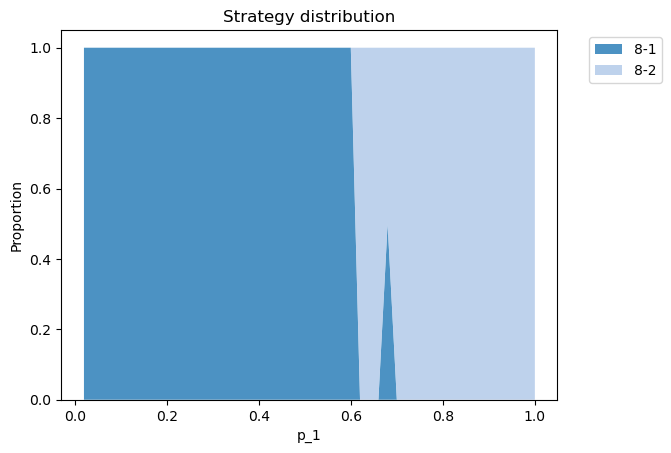

In [21]:
plot_strategy_distribution(df[(df["s_2"] == selected_s_2)
                              & (df["p_2"] == selected_p_2)
                              & (df["s_1"] == selected_s_1)],
                           results["recurrent_states"],
                           x="p_1",
                           x_label="p_1",
                           thresholds=None,
                           cmap=plt.colormaps["tab20"]
                           )

Plot a heatmap of how much harm is caused as we vary 2 parameters

In [22]:
def plot_dilemma_zone_multi_race(table, var='AU_frequency'):
    """Plot the dilemma zone for the multi"""
    plot = plot_heatmap(table,
                ylabel='Risk of layer 1 firms, r_1',
                xlabel='Speed of unsafe layer 1 firms, s_1',
                zlabel=var,
                cmap='inferno',
                )
    return plot

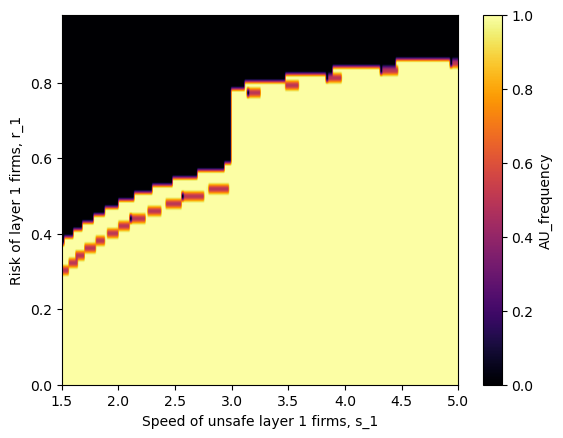

In [23]:
df_plot = df[(df["s_2"] == selected_s_2) & (df["p_2"] == selected_p_2)]
df_plot["AU_frequency"] = df_plot["8-2_frequency"]
table = df_plot.pivot_table(index='r_1', columns='s_1', values="AU_frequency")
plot = plot_dilemma_zone_multi_race(table)

A 3D version of the heatmap

In [24]:
import plotly.graph_objects as go

# Create a pivot table
pivot_table = df_plot.pivot_table(index='r_1', columns='s_1', values="AU_frequency")

fig = go.Figure(data=[go.Surface(z=pivot_table.values, x=pivot_table.columns, y=pivot_table.index, colorscale='Inferno')])

fig.update_layout(title='Frequency of Unsafe Behavior', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

Create plots for each strategy profile's arrival times and safe times as we vary one parameter

In [25]:
def plot_mean_times(df):
    """
    Create lineplots for the mean arrival and safe times as we vary s_1and r_1"""
    
    df_plot = df[(df["s_2"] == selected_s_2) & (df["p_2"] == selected_p_2)]
    df_plot["r_1"] = np.round(df_plot["r_1"], decimals=2)
    set_r_1 = select_unique_values(df_plot["r_1"])
    
    figs = []
    titles = ['Mean Arrival Times for Layer 1',
              'Mean Arrival Times for Layer 2',
              'Mean Time until Safe AI for Layer 1',
              'Mean Time until Safe AI for Layer 2']
    for i, var in enumerate(["arrival_times_layer_1_mean",
                             "arrival_times_layer_2_mean",
                             "safe_times_layer_1_mean",
                             "safe_times_layer_2_mean"]):
        fig = px.line(df_plot[df_plot["r_1"].isin(set_r_1)],
                        x="s_1",
                        y=var,
                        facet_col="r_1")

        fig.update_layout(title=titles[i],
                            xaxis_title='Speed of Layer 1 Firms',
                            yaxis_title='Time',
                            )
        figs.append(fig)
        fig.show()

    return figs

figs = plot_mean_times(df)

In [26]:
# Create a line in a scatterplot for each profile
df_plot = df[(df["s_2"] == selected_s_2) & (df["p_2"] == selected_p_2)
             & (df["s_1"] == selected_s_1)]
fig = go.Figure()
player = 4
profiles = results["payoffs"].keys()
for profile in profiles:
    y_var = f"arrival_times_player_{player}_profile_{profile}"
    x_var = "r_1"
    # Draw scatterplot using plotly
    fig.add_trace(go.Scatter(x=df_plot[x_var], y=df_plot[y_var],
                             mode='markers',
                             name=profile,
                             marker=dict(size=10),
                             ))
fig.update_layout(title=f"Arrival Times for Player {player} across profiles",
                        xaxis_title="Risk of Layer 1 Firms, r_1",
                        yaxis_title="Arrival Time",
                        )
fig.show()
    

It might be easier to start with the results and take your two matrices and reshape
those into a dataframe that is suitable for plotting all of this.

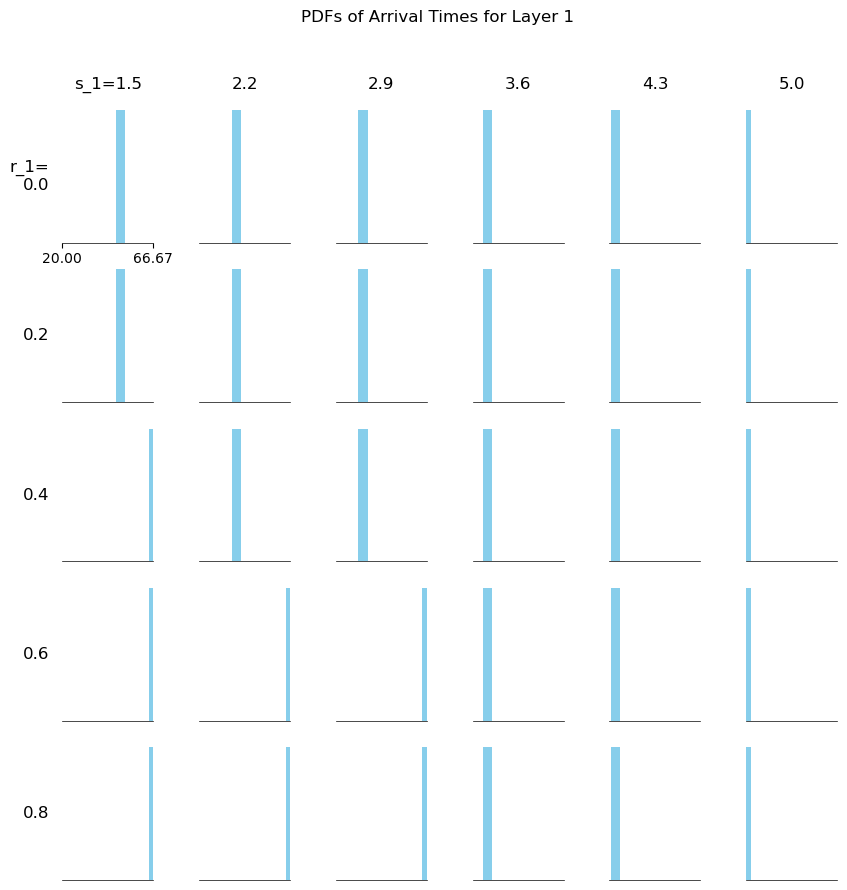

In [27]:
def melt_df_into_states(df):
       """
       Reshape dataframe so that the frequency columns are melted into a signle
       column where each row is a possible state and select outcomes relevant to
       each state.
       """
       columns = df.columns
       frequency_columns = [col for col in columns if col.endswith("_frequency")]
       frequency_columns = [col for col in frequency_columns if len(col.split("-")) == 2]
       state_columns = [f"{state}_frequency" for state in recurrent_states_labels]
       arrival_time_cols = [col for col in columns if col.startswith("arrival_times_L")]
       safe_time_cols = [col for col in columns if col.startswith("safe_times_L")]

       df_reshaped = df.melt(id_vars=["s_1", "s_2", 
                                   "p_1", "p_2",
                                   "r_1", "r_2",
                                   "alpha_1", "alpha_2",
                                   "gamma_1", "gamma_2",
                                   "B_1", "B_2",
                                   "W_1", "W_2",
                                   *arrival_time_cols,
                                   *safe_time_cols],
                            value_vars=frequency_columns,
                            var_name="state",
                            value_name="frequency")
       df_reshaped["state"] = df_reshaped["state"].str.replace("_frequency", "")
       # I need to find the arrival time relevant to the state we are melting to
       # I can do this by finding the state in the arrival_time_cols
       # and then extracting the arrival time from the corresponding column
       df_reshaped["profile"] = ["-".join([str.split(state, "-")[0], str.split(state, "-")[0],
                                          str.split(state, "-")[1], str.split(state, "-")[1]])
              for state in df_reshaped.state]
       df_reshaped["arrival_time_layer_1"] = [df_reshaped[f"arrival_times_L1_profile_{profile}"][i]
                                              for i, profile in enumerate(df_reshaped.profile)]
       df_reshaped["arrival_time_layer_2"] = [df_reshaped[f"arrival_times_L2_profile_{profile}"][i]
                                              for i, profile in enumerate(df_reshaped.profile)]
       df_reshaped["safe_time_layer_1"] = [df_reshaped[f"safe_times_L1_profile_{profile}"][i]
                                           for i, profile in enumerate(df_reshaped.profile)]
       df_reshaped["safe_time_layer_2"] = [df_reshaped[f"safe_times_L2_profile_{profile}"][i]
                                           for i, profile in enumerate(df_reshaped.profile)]
       return df_reshaped

def plot_pdfs_l1(df, selected_s_2=selected_s_2, selected_p_2=selected_p_2):
    df_plot = df[(df["s_2"] == selected_s_2) & (df["p_2"] == selected_p_2)]
    df_reshaped = melt_df_into_states(df_plot)
    fig, axs = plot_generic_grid(df_reshaped, 's_1', 'r_1', 'arrival_time_layer_1')
    axs = add_pdfs_to_grid(axs, df_reshaped, 's_1', 'r_1', 'arrival_time_layer_1', 'frequency')
    fig.suptitle("PDFs of Arrival Times for Layer 1",)
    return fig

fig = plot_pdfs_l1(df)

Now that we have a working model, it is time to prove we understand it.

To do so, I will plot the dilemma zone's and arrival time distributions of
several simple cases. In one set of cases, I limit the choice of strategy of the
labs in Layer 1 to a single strategy, while restricting the choice of strategies
in Layer 2 to just 2 strategies. I then, show how the dilemma zone varies with
a change in the key new parameters introduced by the model, the spillover
parameters, the contestability rates, and risk spillover.

In a second set of cases, I allow Layer 2 to use 4 strategies at once, and
consider cases where Layer 2 starts behind or ahead of Layer 1.

Finally, in a third set of cases, I revisit the above cases about allow all
4 strategies to be present. This time, we look not just at the frequency of
unsafe behaviour, but more directly at the total harm caused.

Aftewards, we move on to discuss how to use this model as a tool for thought
about thinking through tech spillovers in real markets over the last few
decades. Clearly, the field of AI has undergone several eras of development, but
until rather recently the severity of risks appeared rather low. We instead
speculate as to what it would mean for a company to make the trade offs we see
in the model in the face of anticipated future spillovers.
